In [424]:
#!pip install xgboost

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

%matplotlib inline

In [426]:
DATA_DIR = os.path.join(os.getcwd(),'otomoto')
FILE_PATH = os.path.join(DATA_DIR,'29.11.2017_15.53_otomoto.xlsx')

In [427]:
orig_data = pd.read_excel(FILE_PATH)

In [428]:
orig_data.head(3)

,Name,Manufacturer,Year,Mileage,Engine cap.,Engine type,Value,Currency,Negotiation,Netto,Brutto,VAT,Price (EUR),"Price (EUR, VAT refund)",Customs fee (EUR),Total price,Location,Link,DB date
0,superb iii,škoda,2016,60670,2.0,diesel,10000,pln,True,True,False,True,2377.0,2377.0,1643.501,4020.501,nysa,link,2017-11-27 12:16:02
1,megane ii,renault,2006,237000,1.5,diesel,10000,pln,True,False,True,False,2377.0,2377.0,4387.016,6764.016,podwilk,link,2017-11-28 13:03:17
2,linea,fiat,2007,215000,1.3,diesel,10000,pln,True,False,True,False,2377.0,2377.0,3024.914,5401.914,gdańsk,link,2017-11-29 12:03:00


In [429]:
orig_data.describe()

,Year,Mileage,Engine cap.,Value,Price (EUR),"Price (EUR, VAT refund)",Customs fee (EUR),Total price
count,17503.000000,1.750300e+04,17503.000000,17503.000000,17503.000000,17503.000000,1.750300e+04,1.750300e+04
mean,2010.917386,1.458337e+05,2.088785,56531.718791,13483.640826,12378.243161,8.555938e+03,2.093418e+04
std,3.974583,9.835858e+04,7.054309,70236.320649,16737.437340,14445.530415,2.390849e+04,3.109961e+04
min,1995.000000,0.000000e+00,0.100000,2390.000000,2377.000000,1932.520325,8.517500e+02,3.228750e+03
25%,2008.000000,8.100000e+04,1.600000,18900.000000,4492.530000,4425.471545,3.705736e+03,8.842873e+03
50%,2011.000000,1.541490e+05,2.000000,29000.000000,7012.150000,6869.530000,6.091388e+03,1.284219e+04
75%,2014.000000,2.040000e+05,2.000000,59999.000000,14357.080000,13666.301829,8.572463e+03,2.181093e+04
max,2017.000000,2.900400e+06,399.600000,799000.000000,189922.300000,189423.130000,1.264823e+06,1.276945e+06


In [430]:
orig_data.shape

(17503, 19)

In [431]:
orig_data.columns

Index(['Name', 'Manufacturer', 'Year', 'Mileage', 'Engine cap.', 'Engine type',
       'Value', 'Currency', 'Negotiation', 'Netto', 'Brutto', 'VAT',
       'Price (EUR)', 'Price (EUR, VAT refund)', 'Customs fee (EUR)',
       'Total price', 'Location', 'Link', 'DB date'],
      dtype='object')

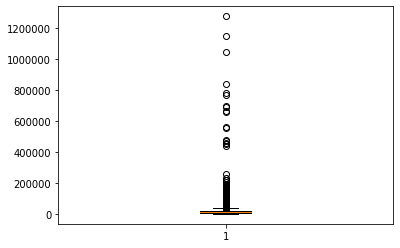

In [432]:
plt.boxplot(orig_data['Total price']);

In [433]:
df = orig_data[orig_data['Total price'] < 50000].reset_index(drop=True)
df.shape

(16114, 19)

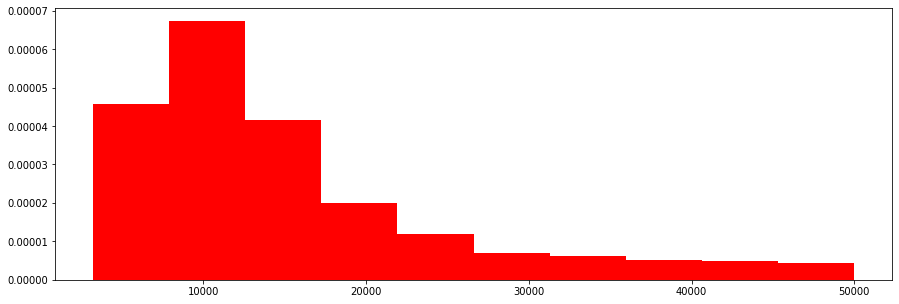

In [434]:
plt.figure(figsize=(15,5))
plt.hist(df['Total price'], density=True, color='r');

In [435]:
df.dtypes

Name                               object
Manufacturer                       object
Year                                int64
Mileage                             int64
Engine cap.                       float64
Engine type                        object
Value                               int64
Currency                           object
Negotiation                          bool
Netto                                bool
Brutto                               bool
VAT                                  bool
Price (EUR)                       float64
Price (EUR, VAT refund)           float64
Customs fee (EUR)                 float64
Total price                       float64
Location                           object
Link                               object
DB date                    datetime64[ns]
dtype: object

In [436]:
for col_name in df.columns:
    if df[col_name].dtype == np.object:
        print(col_name, ': ',  len(df[col_name].value_counts()))

Name :  625
Manufacturer :  46
Engine type :  1
Currency :  2
Location :  1738
Link :  1


In [437]:
print(df['DB date'].min())
print(df['DB date'].max())

2017-11-25 18:14:28
2017-11-29 12:03:00


In [438]:
np.corrcoef(df['Total price'], df.Value)

array([[1.        , 0.94687727],
       [0.94687727, 1.        ]])

In [439]:
list_of_columns = ['Year', 'Mileage', 'Engine cap.', 'Currency', 'Negotiation', 'Netto', 'VAT','Total price']

In [440]:
df = df[list_of_columns]

In [441]:
def change_object_to_OneHots(df, col_name):
    enc = OneHotEncoder()
    X = np.array(df.Currency).reshape(-1,1)
    enc.fit(X)
    OneHot_df = pd.DataFrame(enc.transform(X).toarray())
    OneHot_df.columns= enc.categories_
    for value in enc.categories_:
        name = col_name + '_' + value
        df[name] = OneHot_df[value]
    
    df = df.drop(col_name, axis = 1)
    return df

In [442]:
df = change_object_to_OneHots(df, 'Currency')

In [443]:
X = df.drop('Total price', axis=1)
y = df['Total price'] 

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)

In [445]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12891, 8)
(3223, 8)
(12891,)
(3223,)


In [454]:
model_LR = LinearRegression()
model_LR.fit(np.array(X_train), y_train);

y_predict = model_LR.predict(X_train)
print('TRAIN: ', mae(y_predict, y_train))
y_predict = model_LR.predict(X_test)
print('TEST: ', mae(y_predict, y_test))

TRAIN:  5408.422714962253
TEST:  5531.097680254608


In [494]:
model_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.2)
model_xgb.fit(X_train, y_train);

y_predict = model_xgb.predict(X_train)
print('TRAIN: ', mae(y_predict, y_train))
y_predict = model_xgb.predict(X_test)
print('TEST: ', mae(y_predict, y_test))

C:\Users\skutn\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:18:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAIN:  2921.1319953903294
TEST:  3234.548177964433


In [495]:
random_idx = int(np.random.uniform(0,len(X_test)))
random_car = pd.DataFrame(X_test.iloc[random_idx:random_idx+1])
random_car

,Year,Mileage,Engine cap.,Negotiation,Netto,VAT,Currency_eur,Currency_pln
1462,2013,150000,1.5,True,False,True,0.0,1.0


In [496]:
real_price = y_test.iloc[random_idx]
LR_price = float(model_LR.predict(random_car))
xgb_price = float(model_xgb.predict(random_car))

real_price, LR_price, xgb_price

(5586.658846747969, 16621.021682152757, 7398.43408203125)

In [497]:
model_LR.coef_

array([ 9.22534972e+02, -1.67654886e-02,  8.68249465e+03, -5.09982233e+02,
       -1.99715031e+03,  2.44852452e+03,  1.39586620e+03, -1.39586620e+03])

In [498]:
model_xgb.feature_importances_

array([0.540518  , 0.02944431, 0.34413785, 0.01405936, 0.03212207,
       0.03001498, 0.00970343, 0.        ], dtype=float32)